<a href="https://colab.research.google.com/github/Divyesh-Kanagavel/deep_learning--keras/blob/master/imageGeneration_VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Generation : Varitiational Auto-Encoders and Generative Adversial Networks will be discussed in the context of image generation. These techniques can be used to develop latent spaces for sound, text as well

the idea is to learn a low dimensional latent space which can generate a real image of pixels and the module capable of doing it is called generator(in case of GANs) and decoder(in case of VAEs).

VAEs can be used to learn from structured images where each axis of variation is uniform whereas GANs can be potentially be used for generating realistic images but they lack structure and continuity in their patterns.

Just like embeddings in text generation are concept vector which encode concepts found in original data, latent spaces are concept vectors which encode information in images like smile vector which if controlled can add smile or remove smile from a human face. or adding or removing sunglasses from image. There are concept vectors which independently encode data in the image can be used to have variations in specific axes in the image.

A classical autoencode encodes an original image into a low-dimensional latent space and then a decoder tries to retrieve back the original image from latent space.

Original image ---> compressed information ---> reconstructed image
The constraint placed on encoder is that the latent vector is low-dimensional and is sparse [low memory footprint]

In practice, it is observed that the autoencoders are not good at finding structured low dimensional latent spaces and are not good at compression either.

VAEs augment autoencoders with some statistical tweaks which help in image generation and are powerful [especially for sturctured patterns in images]


VAE - turn the image into a statistical distribution - mean and variance adding a bit of randomness in the process.

Input image ---> a statistical distribution of latent space (mean and variance) ---> pick one random parameter from latent space from this distribution and generate an output image

z = zmean + exp(log_variance) * epsilon
epsilon - > random tensor

epsilon plays an important role here. it makes sure that the small area around mean which is exactly the point where input image has been encoded to also produce some meaningful representation similar to input image ensuring continuity

low dimensionality coupled with continuity implies we learn concepts through latent spaces and a change in any dimension of latent space implies a an axis of variation in image space.


steps
z_mean, z_logvariance = encode(input_image)
z = z_mean + exp(z_logvariance)*epsilon
reconstructed_image = decode(z)
model = Model(input_image, reconstucted_image)



Two losses are used -> reconstruction loss, the diff between original image and reconstructed image
regularization image during encoding -> to try to nudge the distribution to be centered around mean and variance 1 , to prevent overfitting on the training images
Kullback - Leibler loss is used for this purpose
Derivation : https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048

Implementation details:
A conv network is used to map input image to two vectors z_mean, z_var. An important detail is the usage of stride to downsample instead of maxpooling -> whenever the spatial information is completely required ,maxpooling should be avoided as it picks the maximal activated part of the image and others are lost.here we need to retrieve the image back.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
latent_dim = 2
inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32,3,activation="relu", strides = 2, padding="same") (inputs)
x = layers.Conv2D(64,3,activation="relu", strides = 2, padding="same") (x)
x = layers.Flatten() (x)
x = layers.Dense(16, activation="relu") (x)
z_mean = layers.Dense(latent_dim, name="z_mean") (x)
z_log_var = layers.Dense(latent_dim, name="z_log_var") (x)

encoder = keras.Model(inputs, [z_mean, z_log_var], name="encoder")




In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
import tensorflow as tf
class Sampler(layers.Layer):
  def call(self,z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size,z_size))
    return z_mean + tf.exp(0.5*z_log_var) * epsilon

In [ ]:
#decoder - do the reverse of what was done during encoding
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation="relu") (latent_inputs)
x = layers.Reshape((7,7,64)) (x)
x = layers.Conv2DTranspose(64,3,strides = 2, padding="same", activation="relu") (x)
x = layers.Conv2DTranspose(32,3,strides = 2, padding="same", activation="relu") (x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same") (x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

This is a model which does not have targets -> self supervised learning , the target is the original image itself.
we are departing from supervised learning, hence it is better to abandon keras fit function and write a class to train the model and write a custom fit function

In [ ]:
class VAE(keras.Model):
  def __init__(self,encoder,decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.regularization_loss_tracker = keras.metrics.Mean(name="regularization_loss")
  @property
  def metrics(self):
    return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.regularization_loss_tracker]
  def train_step(self,data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = self.encoder(data)
        z = self.sampler(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)))
        regularization_loss = -0.5 * (1+z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # refer to link shared in the text for markdown
        total_loss = reconstruction_loss + tf.reduce_mean(regularization_loss)
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.regularization_loss_tracker.update_state(regularization_loss)
    return {"total_loss": self.total_loss_tracker.result(), "reconstruction_loss":self.reconstruction_loss_tracker.result(), "regularization_loss":self.regularization_loss_tracker.result()}



In [ ]:
import numpy as np
(x_train,_), (x_test,_) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype("float32") / 255
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly = True)
vae.fit(mnist_digits, epochs=30, batch_size=128)


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30


547/547 [==============================] - 39s 60ms/step - total_loss: 207.4099 - reconstruction_loss: 204.5053 - regularization_loss: 2.9046
Epoch 2/30
547/547 [==============================] - 34s 63ms/step - total_loss: 169.5535 - reconstruction_loss: 165.5800 - regularization_loss: 3.9735
Epoch 3/30
547/547 [==============================] - 34s 62ms/step - total_loss: 161.4359 - reconstruction_loss: 157.6245 - regularization_loss: 3.8113
Epoch 4/30
547/547 [==============================] - 28s 52ms/step - total_loss: 157.6495 - reconstruction_loss: 153.8176 - regularization_loss: 3.8320
Epoch 5/30
547/547 [==============================] - 31s 56ms/step - total_loss: 155.5102 - reconstruction_loss: 151.6617 - regularization_loss: 3.8484
Epoch 6/30
547/547 [==============================] - 28s 52ms/step - total_loss: 153.9630 - reconstruction_loss: 150.0881 - regularization_loss: 3.8750
Epoch 7/30
547/547 [==============================] - 29s 53ms/step - total_loss: 152.7849 - 

Once the network is trained, the decoder can be used to create more images from latent space vectors

In [ ]:
import matplotlib.pyplot as plt

n = 30
digit_size= 28
figure = np.zeros((digit_size * n, digit_size * n))


In [ ]:
figure.shape

(840, 840)

In [ ]:
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]


In [ ]:
grid_x.shape, grid_y.shape

((30,), (30,))

In [ ]:
grid_x

array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
       -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
       -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
        0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
        0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
        0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ])

In [ ]:
for i, yi in enumerate(grid_y):
  for j,xi in enumerate(grid_x):
    z_sample = np.array([[xi,yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size,digit_size)
    figure[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit


1/1 [==============================] - 0s 26ms/step


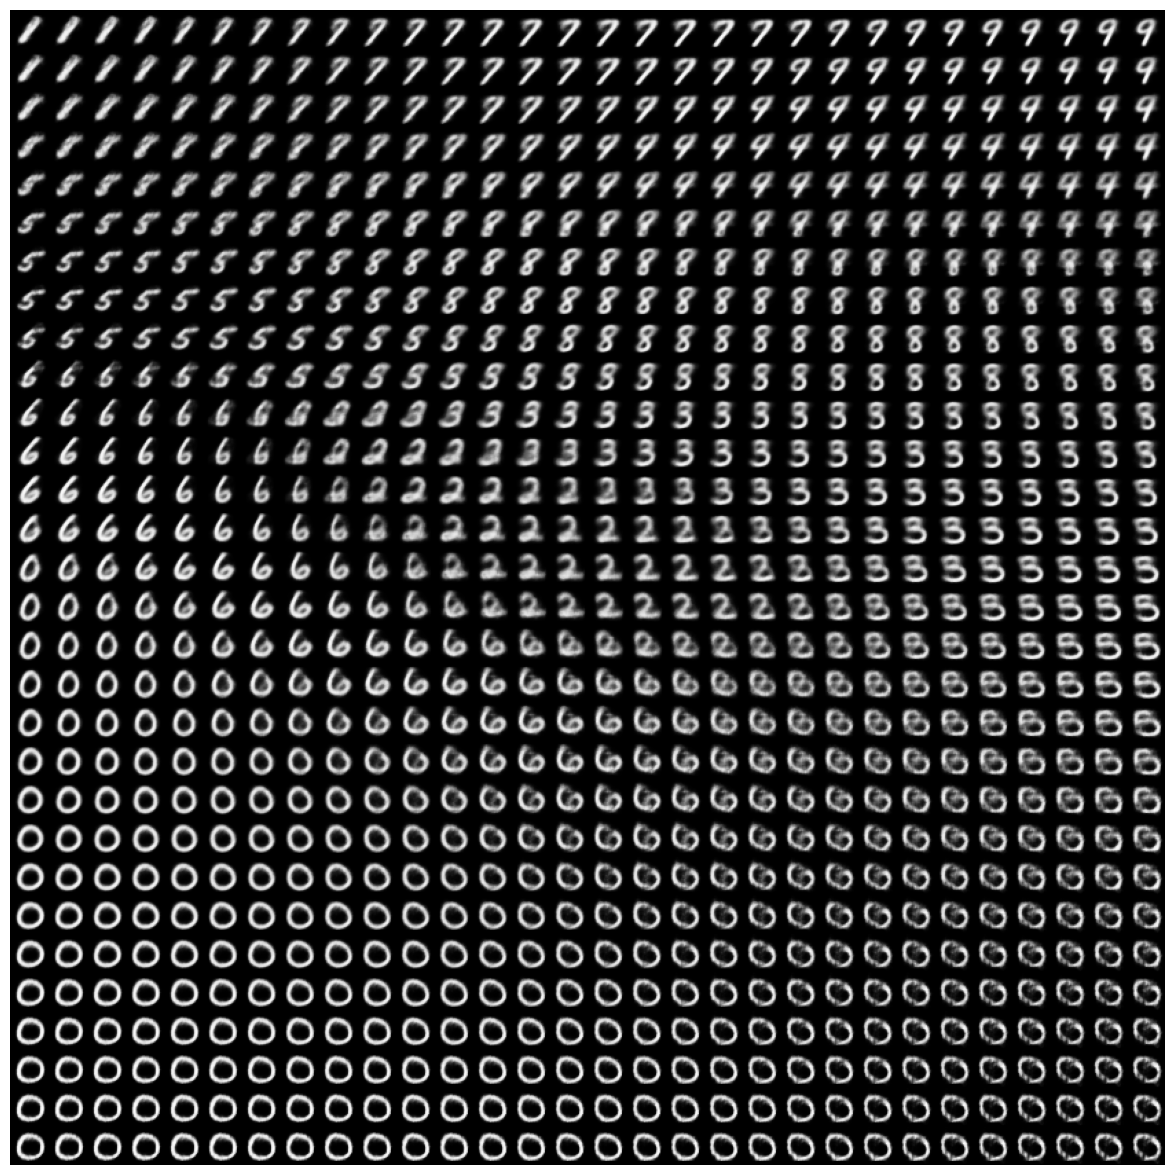

In [ ]:
plt.figure(figsize=(15,15))
start_range = digit_size//2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x,1)
sample_range_y = np.round(grid_y,1)
plt.xticks(pixel_range,sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap = 'Greys_r')


The decoder is able to produce digits starting from latent space vector -> we can also see with sample values close in latent vector, we see the same digit being produced and as the value changes we see a shift to other digits as a sort of smooth transition. we can also see some concepts like 1ness 2 ness 5 ness etc

VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space or showing a starting image slowly morphing into different images in a continuous way.
GANs enable the generation of realistic single-frame images but may not induce latent spaces with solid structure and high continuity.

Most successful practical applications employ VAE and now diffusion models.
Academic research still works with GAN to produce realistic human faces.


Artificial image generation using GANs

GANs consists of two networks : the forger network which tries to come up with realistic replicas of input images and the expert network ,which tries to distinguish between real and generated images, this way with training, the forger network becomes competent in producing realistic fakes and expert network becomes increasingly competent in singling out the fakes

Generator : the forger network which takes as input a random point in latent space and tries to produce a synthetic image
Discriminator (adversary) : the network classifies the image as from training dataset or generated by Generator

VAE latent space is structured and continuous and thus guarantees some meaning in image produced, in GANs there is limited guarantee as there is no structure or continuity in latent space -> there is no convergence to a local minima instead the attempt is to reach a equilibrium between generator and discriminator. the stability criterion for convergence are differetn and hence GANs are notoriously difficult to train -> very sensitive to arch and params changes. require a set of conditions for it to generate reasonably good images
the output is either too good or very bad. mathematically hard to understand the convergence criterion

The bare GAN idea is implemented here. Advanced GANs like STYLEGAN2 which can produce realistic images require more effort and trial&error with some tweaks.
The variant used here is Deep Convnets GAN (DCGAN).

dataset used is CelebA (Celebrities Faces Attributes). the images of celebrities will be resized to 64X64 for faster training. the objective of GAN is to come up with 64X64 image of human faces [celebrities]

details
Generator network takes a seed latent vector and produces an image of size (64X64X3)
discriminator consumes the output from generator and produces a binary output
these two are chained together gan(x) = discriminator(generator(x))
To train the generator we use the gradients of the weights of the generator with resepect to loss -> move the weights such that the generator's output is classified as real by discriminator.

The process of training and tuning gan is notoriously difficult. a bag of tricks is employed to make sure the training achieves the desired objective.

Sparsity : Deep learning matrices are often sparse and are desirable,but in GANs sparsity is a curse. with sparse weights and gradients , the training is not stable as we don't reach a static local optimum instead we try to reach a dynamic equilibrium between two networks.

Instead of maxpooling, strided convolutions are used.and the activation function used is leaky relu instead of relu .it allows small negative activation values as well instead of clipping them to zeros.
In generated images, it is common to see checkered artifacts. this especially happens when kernel size is not divisible by stride . to prevent checkered artifacts, we choose kernel size and stride being divisible.

In [1]:
# getting the celeba dataset
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=9a0f9f63-1b50-4ef1-956c-38da1fb446c0
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:23<00:00, 61.7MB/s]


In [2]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode = None,
    image_size=(128,128),
    batch_size = 32,
    smart_resize = True
) # take in only images and smart_resize will crop and resize such that aspect ratio is preserved and details are not lost

Found 202599 files belonging to 1 classes.


In [3]:
dataset = dataset.map(lambda x: x / 255.)

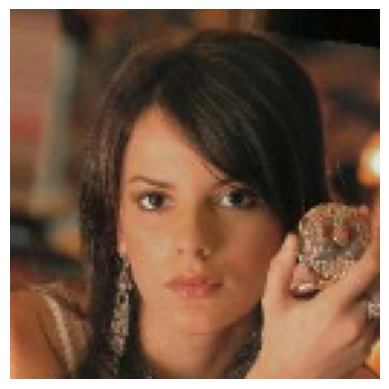

In [4]:
#visualize the image
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy()*255).astype("int32")[0])
  break

In [17]:
#the discriminator
# classifies the image generated by generator into real or fake.Sometimes while training GAN, the generator gets stuck with images that are noise
#Adding dropout in discriminator mitigates this issue

from tensorflow.keras import layers
discriminator = keras.Sequential([
    keras.Input(shape=(128,128,3)),
    layers.Conv2D(64, kernel_size=4, strides = 2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides = 2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides = 2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),


],
    name = "discriminator"
)


In [18]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

In [7]:
#Generator network - same tweaks : use conv2DTranspose to get back original image and use leaky Relu to avoid sparsity
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(16*16*128),
    layers.Reshape((16,16,128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides = 2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides = 2, padding = "same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides = 2, padding = "same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size = 5, padding= "same", activation = "sigmoid"),
], name="generator")

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 256)       0 

The adverserial network

Steps:
Draw random points from latent space
Generate images using generators
Mix the images with real images
Train discriminator to detect fake images
again draw random points from latent space
generate images from these points
train generator against discriminator labelling all as 1 trying to fool the discriminator

In [14]:
import tensorflow as tf
class GAN(keras.Model):
  def __init__(self,discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
    self.d_loss_tracker = keras.metrics.Mean(name="d_loss")

  @property
  def metrics(self):
    return [self.g_loss_tracker,self.d_loss_tracker]

  def compile(self,d_optimizer, g_optimizer ,loss_function):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_function = loss_function

  def train_step(self,real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
    generated_image = self.generator(random_latent_vector)
    #combine real and fake generated images
    combined_images = tf.concat([generated_image, real_images], axis=0)
    combined_labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))],axis=0)
    combined_labels += 0.05*tf.random.uniform(tf.shape(combined_labels)) # adds randomness to labels -> aids training to reach equilibrium

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_function(combined_labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.ones((batch_size,1)) # all labels are 1 i.e real, if the discriminator says these are real, loss will be less and hence win for generator,
                                                # else, loss will be high and generator weights will be trained to fool discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vector))
      g_loss = self.loss_function(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)

    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)

    return {"d_loss" : self.d_loss_tracker.result(), "g_loss" : self.g_loss_tracker.result() }



In [15]:
# a class to monitor GAN results
class GANMonitor(keras.callbacks.Callback):
  def __init__(self,num_img =3, latent_dim = 128):
    super().__init__()
    self.num_img = num_img
    self.latent_dim = latent_dim
  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_imgs):
      img = keras.utils.array_to_img(generated_images[i])
      plt.imshow(img)
      plt.axis("off")
      plt.show()

In [ ]:
epochs = 2
gan = GAN(discriminator, generator, 128)
gan.compile(keras.optimizers.Adam(learning_rate = 0.0001), keras.optimizers.Adam(learning_rate=0.0001), keras.losses.BinaryCrossentropy())
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim = 128)])

